In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import Ridge
from scipy.stats import pearsonr
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
domains = ['brand', 'good', 'trait', 'food', 'occupation', 'risk', 'people']
dims = [('sincere','exciting'),
        ('hedonic','utilitarian'),
        ('masculine','feminine'),
        ('tasty','nutritious'),
        ('significance','autonomy'),
        ('dread-inducing','unknowable'),
        ('warm', 'competent')]

In [3]:
with open("data/dict_of_Xs.pickle", "rb") as handle:
    dict_of_Xs = pickle.load(handle)
    
with open("data/dict_of_individual_ys.pickle", "rb") as handle:
    dict_of_individual_ys = pickle.load(handle)

In [4]:
ridge = Ridge(alpha=10) # pre-reg'd analyses revealed ridge with alpha=10 had highest rsquared across dimensions

In [5]:
dict_of_individual_y_preds = dict()

# Check dimension-specific distributions of percentage of items not rated

In [6]:
mean_missing = pd.DataFrame([(dim, df.isna().sum(axis='columns').mean()) for dim, df in dict_of_individual_ys.items()], 
                             columns=['dim','mean_missing_items'])
mean_missing

,dim,mean_missing_items
0,sincere,20.882353
1,exciting,20.882353
2,hedonic,4.000000
3,utilitarian,3.282609
4,masculine,26.863636
5,feminine,26.909091
6,tasty,9.500000
7,nutritious,8.437500
8,significance,6.809524
9,autonomy,6.809524


In [7]:
mean_missing.mean()

mean_missing_items    13.265121
dtype: float64

# Train models

In [8]:
for domain, dim_pair in tqdm(zip(domains, dims)):
    X = dict_of_Xs[domain].values
#     X = X[:100]
    for dim in dim_pair:
        all_individual_preds = np.zeros(shape=dict_of_individual_ys[dim].shape)
#         all_individual_preds = np.zeros(shape=(dict_of_individual_ys[dim].shape[0], 100))
        for individual_idx, y in enumerate(dict_of_individual_ys[dim].values):
#             y = y[:100]
            y_preds = np.zeros(shape=len(y))
            loo = LeaveOneOut()
            for train_index, test_index in loo.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train = y[train_index].astype(float)

                y_notna_idxs = ~np.isnan(y_train)
                y_train = y_train[y_notna_idxs]
                X_train = X_train[y_notna_idxs]

                ridge.fit(X=X_train, y=y_train)
                y_pred = ridge.predict(X=X_test)[0]
                y_preds[test_index] = y_pred
            all_individual_preds[individual_idx] = y_preds
        individual_predictions = pd.DataFrame(all_individual_preds, columns=dict_of_individual_ys[dim].columns)
#         individual_predictions = pd.DataFrame(all_individual_preds, columns=dict_of_individual_ys[dim].columns[:100])
        dict_of_individual_y_preds[dim] = individual_predictions

7it [01:50, 15.80s/it]


In [9]:
with open("data/dict_of_individual_y_preds.pickle", "wb") as handle:
    pickle.dump(dict_of_individual_y_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Compute and visualize actual vs pred correlations

In [10]:
if 'dict_of_individual_y_preds' not in globals():
    with open("data/dict_of_individual_y_preds.pickle", "rb") as handle:
        dict_of_individual_y_preds = pickle.load(handle)

In [11]:
all_participant_rs = []
dims = dict_of_individual_ys.keys()
for dim in dims:
    df_ys      = dict_of_individual_ys[dim]
#     df_ys      = dict_of_individual_ys[dim].iloc[:,:100]
    df_y_preds = dict_of_individual_y_preds[dim]
    dim_rs = []
    for ys, y_preds in zip(df_ys.values, df_y_preds.values):
        y_not_na_idx = ~np.isnan(ys.astype(float))

        ys_not_na      = ys[y_not_na_idx]
        y_preds_not_na = y_preds[y_not_na_idx]
        
        r, _ = pearsonr(ys_not_na, y_preds_not_na)
        dim_rs.append(r)
    all_participant_rs.append(dim_rs)
all_participant_rs_df = pd.DataFrame(all_participant_rs, index=dims).T

In [12]:
all_participant_rs_df_stacked = all_participant_rs_df.stack().reset_index()
all_participant_rs_df_stacked.columns = ['participant_number', 'Judgment Dimension', 'Correlation of Pred vs Actual']

In [13]:
all_participant_rs_df_stacked.to_csv('results/individual-level_mapping_model_results.csv', index=False)

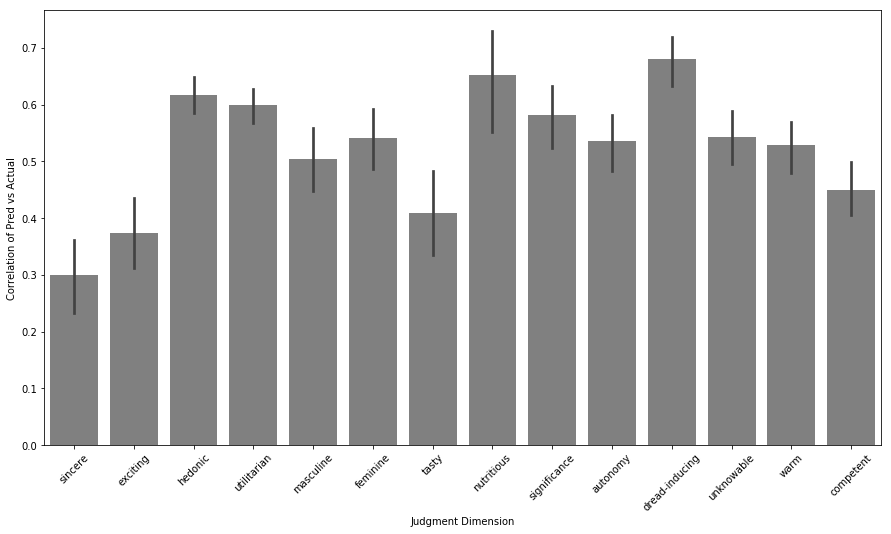

In [14]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45);
sns.barplot(data=all_participant_rs_df_stacked, x='Judgment Dimension', y='Correlation of Pred vs Actual', color='gray');
plt.savefig('figures/individual_level_mapping_pred_v_actual_correlation_barplots.png')

In [15]:
all_participant_rs_df_stacked.groupby('Judgment Dimension').mean().mean()

participant_number               17.357143
Correlation of Pred vs Actual     0.522605
dtype: float64